In [3]:
# Import the full met.ie dataset (downloaded from https://www.met.ie/climate/available-data/historical-data)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# some functions
# function to split a year into months and return the 12 monthly dataframes
#def split_month(the_dataframe, keys):
  

In [5]:
all_data_df = pd.read_csv("data/Athenry_met/hly1875.csv", skiprows=17)
# Adding a pandas datetime field 



In [6]:
all_data_df.columns.values

array(['date', 'ind', 'rain', 'ind.1', 'temp', 'ind.2', 'wetb', 'dewpt',
       'vappr', 'rhum', 'msl', 'ind.3', 'wdsp', 'ind.4', 'wddir'],
      dtype=object)

In [7]:
# set index to be datetime
all_data_df['datetime'] = pd.to_datetime(all_data_df['date'])
all_data_df = all_data_df.set_index(all_data_df['datetime'])
all_data_df.drop(columns=['date'], inplace=True)

In [8]:
# taking the data for 1 year only - 2021
year_start = "2015-01-01 00:00:00"
year_end = "2022-12-31 23:00:00"

year_data_df = all_data_df.loc[year_start : year_end].copy()
year_data_df



,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl,ind.3,wdsp,ind.4,wddir,datetime
datetime,,,,,,,,,,,,,,,
2015-01-01 00:00:00,0,0.0,0,8.3,0,7.2,5.9,9.3,84,1019.7,2,9,2,210,2015-01-01 00:00:00
2015-01-01 01:00:00,0,0.0,0,8.3,0,7.2,5.8,9.2,84,1019.5,2,10,2,200,2015-01-01 01:00:00
2015-01-01 02:00:00,0,0.0,0,8.2,0,7.1,5.8,9.2,84,1018.8,2,10,2,210,2015-01-01 02:00:00
2015-01-01 03:00:00,0,0.0,0,9.3,0,7.7,5.7,9.2,78,1018.1,2,11,2,200,2015-01-01 03:00:00
2015-01-01 04:00:00,0,0.0,0,9.6,0,8.3,6.7,9.8,81,1016.6,2,9,2,200,2015-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,0,0.0,0,4.4,0,4.2,4.0,8.1,96,992.9,2,3,2,40,2022-12-31 19:00:00
2022-12-31 20:00:00,0,0.0,0,4.5,0,4.3,4.1,8.2,97,993.4,2,1,2,50,2022-12-31 20:00:00
2022-12-31 21:00:00,0,0.0,0,4.6,0,4.4,4.2,8.2,96,994.0,2,3,2,30,2022-12-31 21:00:00


In [9]:
# Some initial data investigation
# plot a histogram of rainfall for the year 2021
import numpy as np
#data_2021_df = data_2021_df.fillna(np.nan)
# replace blankspace with nan - https://stackoverflow.com/questions/13445241/replacing-blank-values-white-space-with-nan-in-pandas
year_data_df = year_data_df.replace(r'^\s+$', np.nan, regex=True)


#plt.hist(data_2021_df['rain'])


In [10]:
# Take 3 met variables - hourly rainfall, temperature, sealevel pressure
year_data_df['rain'] = year_data_df['rain'].astype(float)
year_data_df['temp'] = year_data_df['temp'].astype(float)
year_data_df['msl'] = year_data_df['msl'].astype(float)


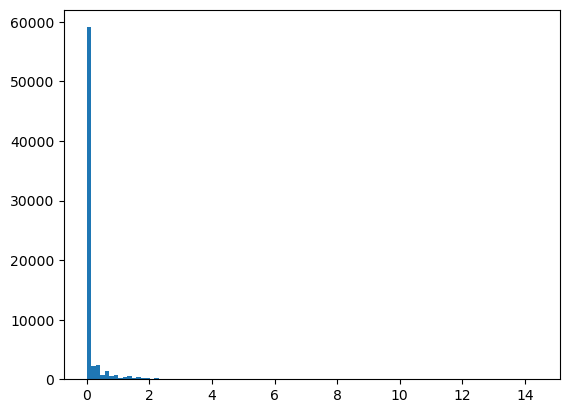

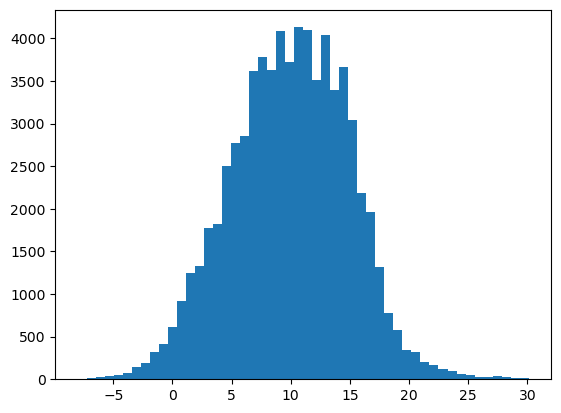

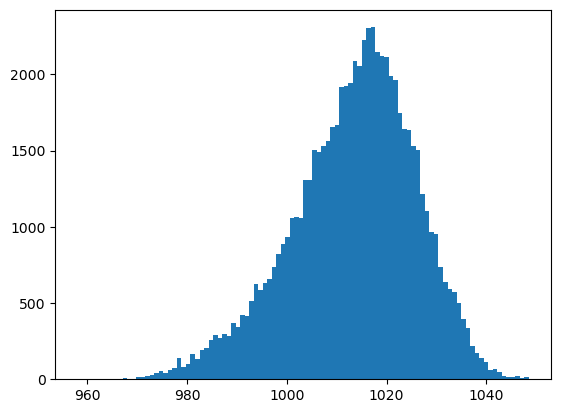

In [11]:
plt.hist(year_data_df['rain'], bins=100)
plt.show()
plt.hist(year_data_df['temp'], bins=50)
plt.show()
plt.hist(year_data_df['msl'], bins=100)
plt.show()


# Plots of 8 years worth of met data at Athenry weather station
- Histogram of data for rainfall is highly skewed towards 0, so many hours where there is no rain (i.e., it's not raining all the time in Athenry!)
- Histogram of temperature appears to be normally distributed.
- Histogram of pressure similarly appears to be approximately normally distributed with a skew towards lower pressure - requires more research.



# Rainfall distribution - analysis and synthesisation
 - Rainfall over a period of time can follow an exponential distribution [https://www.realclimate.org/index.php/archives/2017/11/a-brief-review-of-rainfall-statistics/] 
 - The frequency of rainy days by classifying a "rainy" day as one in which the total rainfall is >1mm. The frequency of rainy days, fw, can then be calculated.
 - From 8 years of data, the frequency of rainy days is 0.5, i.e., So 1 in 2 days has rainfall.
 - For the days that are classified as rainy, the mean daily rainfall is 6.7mm
 - It is possible to generate data for 1 year to synthesise daily rainfall totals if we first assign a binomial distribution to classify a day as rainy or dry and then generate lognormal random data to model rainfall totals for the days which were assigned rainy in the first distribution.



 
  
 https://stackoverflow.com/questions/2896179/fitting-a-gamma-distribution-with-python-scipy
 - [https://en.wikipedia.org/wiki/Gamma_distribution]
 https://www.geeksforgeeks.org/how-to-do-exponential-and-logarithmic-curve-fitting-in-python/

0.5037645448323066
2922
1472
rain    44.1
dtype: float64
rain    1.1
dtype: float64
[ 1.     3.205  5.41   7.615  9.82  12.025 14.23  16.435 18.64  20.845
 23.05  25.255 27.46  29.665 31.87  34.075 36.28  38.485 40.69  42.895]
(20,)
(21,)
(20,)


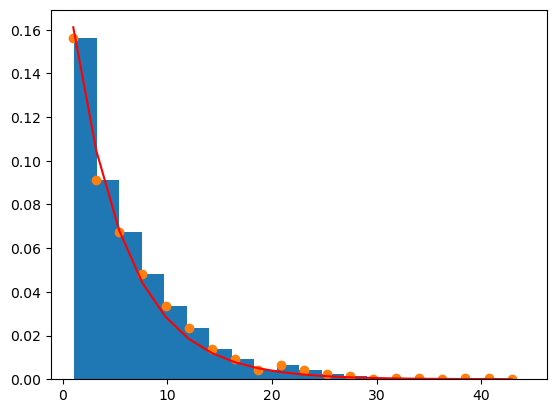

In [80]:
# Do some analysis on the rainfall data over 8 years.
# sum the rainfall per day
import scipy.stats as stats
year_data_df[['rain', 'datetime']]
daily_rain_sum = year_data_df[['rain', 'datetime']].groupby(pd.Grouper(key='datetime', freq='D')).sum()
max_rain = daily_rain_sum.max()
min_rain = daily_rain_sum.min()
# frequency of rainy days with criterion of >1mm rainfall
fw = (daily_rain_sum['rain']>1).sum() / len(daily_rain_sum)
#fw = df_rainy_day.sum()
print(fw)
print(len(daily_rain_sum))
print((daily_rain_sum['rain']>1).sum())
daily_rain_rainydays = daily_rain_sum[daily_rain_sum['rain']>1]
print(daily_rain_rainydays.max())
print(daily_rain_rainydays.min())
no_bins = 20
# returns the normalised data for the histogram (area under curve =1)
n, bins, patches = plt.hist(daily_rain_rainydays, bins=no_bins, density=True)

x = np.arange(1, 44.1, 44.1/no_bins)
print(x)
#plt.plot(x,n)
#mean_daily_rain = daily_rain_rainydays.mean()
#std_daily_rain = daily_rain_rainydays.std()
#print(len(x))
plt.plot(x, n, 'o')
# Use curve_fit as in: https://stackoverflow.com/questions/50448199/lognormal-curve-fit
#y1 = n / np.trapz(x, n)
print(n.shape)
print(bins.shape)
print(x.shape)
# PDF for the log distribution 
def f(x, lamda_1):
  return lamda_1*np.exp(-1*lamda_1*x)
#print(bins)
#print(x)
#print(n)
from scipy.optimize import *

params, extras = curve_fit(f, x, n)

params
# fit a log normal curve


lamda_1 = 0.196
pdf_expon = (lamda_1*np.exp(-1*lamda_1*x))

plt.plot(x, pdf_expon, 'r')
# set up a random generator for log normal 
#s = np.random.lognormal(mean_daily_rain, std_daily_rain, 2920)
#count, bins, ignored = plt.hist(s, 20, density=True, align='mid')
#plt.show()

#x = np.linspace(min(bins), max(bins), 100)
#pdf = (np.exp(-(np.log(x) - mean_daily_rain)**2 / (2 * std_daily_rain**2))
#       / (x * std_daily_rain * np.sqrt(2 * np.pi)))

#plt.plot(x, pdf, linewidth=2, color='r')
#plt.axis('tight')
#print("mean_rain", mean_daily_rain)
#(n, bins, patches) = plt.hist(daily_rain_rainydays, bins=20, label='hst')
#plt.show()
#print(n)
#plt.plot(n)
#plt.show()
#logn = np.log(n)
#logn[np.isneginf(logn)] = 0
#plt.plot(logn)
#plt.show()

[4.80e+03 2.30e+02 2.88e+02 8.70e+01 7.40e+01 1.14e+02 3.70e+01 5.60e+01
 6.00e+01 2.30e+01 2.20e+01 3.50e+01 9.00e+00 1.90e+01 1.00e+01 9.00e+00
 1.50e+01 3.00e+00 4.00e+00 1.30e+01 5.00e+00 6.00e+00 3.00e+00 5.00e+00
 3.00e+00 0.00e+00 4.00e+00 2.00e+00 2.00e+00 1.00e+00 2.00e+00 0.00e+00
 3.00e+00 2.00e+00 1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 2.00e+00 0.00e+00 2.00e+00 0.00e+00
 0.00e+00 1.00e+00]


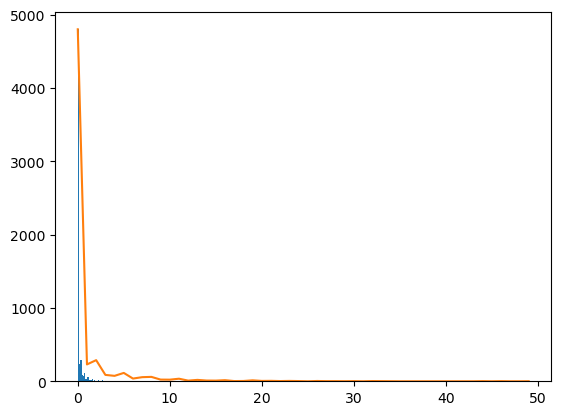

C:\Users\eilis.donohue\AppData\Local\Temp\ipykernel_2884\1941714562.py:14: RuntimeWarning: divide by zero encountered in log
  logn = np.log(n)


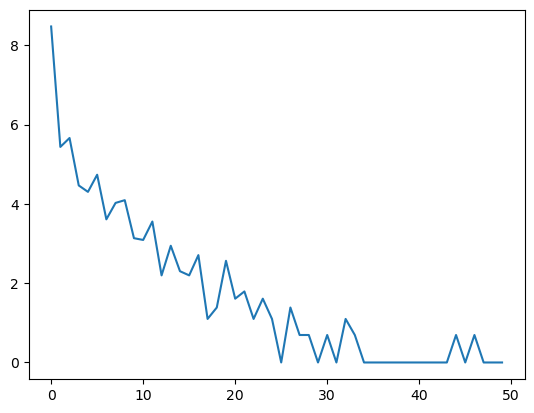

5952
[0. 0. 0. ... 0. 0. 0.]


In [13]:
# https://datascience.stackexchange.com/questions/32139/extract-all-the-data-of-a-particular-month-from-dataset-of-different-years
# put this in a function (call in a loop)
Jan_data = year_data_df['datetime'].dt.month.between(1,1)

jan_data_df = year_data_df.loc[Jan_data]

#plt.hist(jan_data_df['rain'], bins=100)
jan_data_np_rain = jan_data_df['rain'].to_numpy()
(n, bins, patches) = plt.hist(jan_data_np_rain, bins=50, label='hst')

print(n)
plt.plot(n)
plt.show()
logn = np.log(n)
logn[np.isneginf(logn)] = 0
plt.plot(logn)
plt.show()
#sns.displot(jan_data_df, x="rain", kind="kde")
#from scipy.stats import gamma
#from scipy.optimize import curve_fit
#initial_guess = [1,0.5]
#hist, bin_edges = np.histogram(jan_data_df['rain'], bins='auto', density=True)
#bin_centres = (bin_edges[:-1]+bin_edges[1:])/2
#def gamma_pdf(x, k, theta):
#  return gamma.pdf(x, a=k, scale=theta)

#params, covariance = curve_fit(gamma_pdf, bin_centres, hist, p0=initial_guess)
#shape_param, scale_param = params

#print(params)
#x_values = np.linspace(jan_data_df['rain'].min(), jan_data_df['rain'].max(), 100)
#plt.plot(x_values, gamma_pdf(x_values, shape_param, scale_param), 'r-', label='Fitted Gamma Distribution')
#data = gamma.rvs(a=shape_param, scale=scale_param, size=744)
#plt.plot(data)
#plt.plot(jan_data_np_rain)

#plt.legend()
#plt.show()
print(len(jan_data_np_rain))
print(jan_data_np_rain)


[6.590e+04 2.398e+03 8.790e+02 4.290e+02 2.210e+02 1.510e+02 5.900e+01
 2.400e+01 2.100e+01 7.000e+00 9.000e+00 6.000e+00 3.000e+00 4.000e+00
 0.000e+00 0.000e+00 2.000e+00 0.000e+00 1.000e+00 1.000e+00]


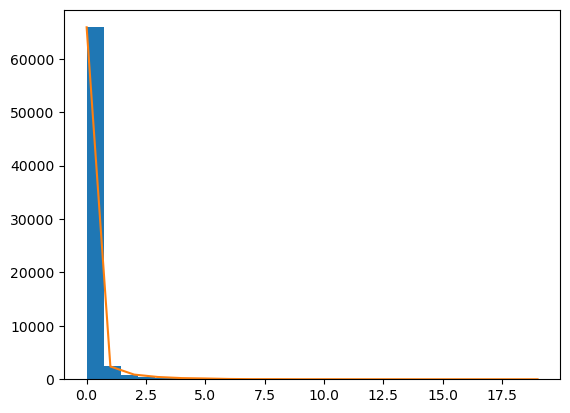

C:\Users\eilis.donohue\AppData\Local\Temp\ipykernel_2884\1577368885.py:11: RuntimeWarning: divide by zero encountered in log
  logn = np.log(n)


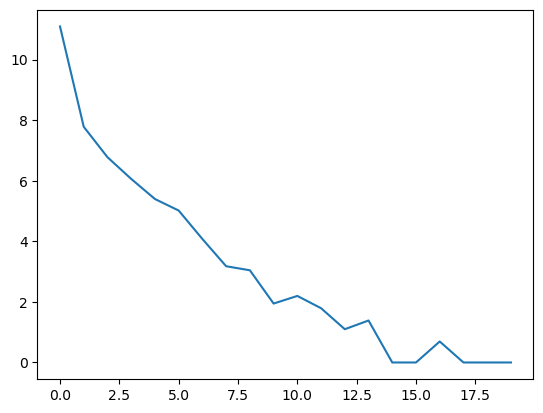

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[3.23778574e+00 9.52978073e-04]


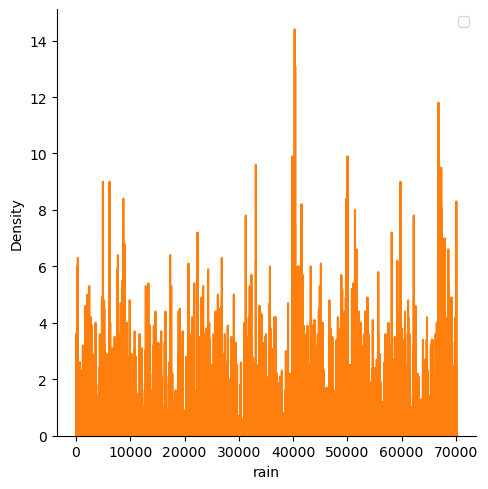

70128
[0. 0. 0. ... 0. 0. 0.]


In [14]:
# https://datascience.stackexchange.com/questions/32139/extract-all-the-data-of-a-particular-month-from-dataset-of-different-years
# put this in a function (call in a loop)

#plt.hist(jan_data_df['rain'], bins=100)
jan_data_np_rain = year_data_df['rain'].to_numpy()
(n, bins, patches) = plt.hist(jan_data_np_rain, bins=20, label='hst')

print(n)
plt.plot(n)
plt.show()
logn = np.log(n)
logn[np.isneginf(logn)] = 0
plt.plot(logn)
plt.show()
sns.displot(jan_data_df, x="rain", kind="kde")
from scipy.stats import gamma
from scipy.optimize import curve_fit
initial_guess = [1,0.5]
hist, bin_edges = np.histogram(jan_data_df['rain'], bins='auto', density=True)
bin_centres = (bin_edges[:-1]+bin_edges[1:])/2
def gamma_pdf(x, k, theta):
  return gamma.pdf(x, a=k, scale=theta)

params, covariance = curve_fit(gamma_pdf, bin_centres, hist, p0=initial_guess)
shape_param, scale_param = params

print(params)
x_values = np.linspace(jan_data_df['rain'].min(), jan_data_df['rain'].max(), 8760)
#plt.plot(x_values, gamma_pdf(x_values, shape_param, scale_param), 'r-', label='Fitted Gamma Distribution')
data = gamma.rvs(a=shape_param, scale=scale_param, size=8760)
plt.plot(data)
plt.plot(jan_data_np_rain)

plt.legend()
plt.show()
print(len(jan_data_np_rain))
print(jan_data_np_rain)
